# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

2. Examine the State and Action Spaces
In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from ddpg_multiAgent import MultiAgent
multiAgent = MultiAgent(state_size=state_size, action_size=action_size, random_seed=2, num_agents = num_agents)
# print('params=', multiAgent.params)

from constant_params import constParams
params = constParams()

def maddpg(n_episodes=params.max_episodes, max_t=500000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    scores_movingAvg = []
    scores_mean = []
    
    for i_episode in range(1, n_episodes+1):        
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations            # get the current state
        multiAgent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
#             epsilon = max(params.epsilon_start-i_episode*params.epsilon_decay_rate,0.1)#decaying epsilon value
            epsilon = 0.1 
        
            action = multiAgent.act(state, epsilon, add_noise=True)# select an action (for each agent)
#             action = np.random.randn(num_agents, action_size) # select an action (for each agent)
#             action = np.clip(action, -1, 1)                  # all actions between -1 and 1
#             print('states=', state)
#             print('actions=', action)
            env_info = env.step(action)[brain_name]           # send all actions to tne environment
#             print('envinfo=', env_info)
            next_state = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            multiAgent.step(state, action, rewards, next_state, dones)    
            scores += env_info.rewards                         # update the score (for each agent)
            state = next_state                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
    
    
        scores_deque.append(np.max(scores))
        scores_movingAvg.append(np.mean(scores_deque))
        
        if i_episode % 10 == 0:
#             print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            print('\rEpisode {}\tAverage Score: {:.2f}\tAgent 1 Score: {:.2f}\tAgent 2 Score: {:.2f}'.format(i_episode,scores_movingAvg[-1],scores[0],scores[1]))
#             print('epsilon=', epsilon)

        if np.mean(scores_deque)>= 0.5 and i_episode >= 100:
            print('\n Environment solved in {:d} episodes! \t Average Score: {:2f}'.format(i_episode, np.mean(scores_deque)))
            for i, agent in enumerate(multiAgent.ddpg_agents):
                torch.save(agent.actor_local.state_dict(), '\trainedNN_actor_{}.pth'.format(i)) 
                torch.save(agent.critic_local.state_dict(), '\trainedNN_critic_{}.pth'.format(i)) 
    return scores, scores_movingAvg

scores, scores_movingAvg = maddpg()
    
 

Episode 10	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 20	Average Score: 0.00	Agent 1 Score: -0.01	Agent 2 Score: 0.00
Episode 30	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 40	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 50	Average Score: 0.00	Agent 1 Score: -0.01	Agent 2 Score: 0.00
Episode 60	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 70	Average Score: 0.00	Agent 1 Score: -0.01	Agent 2 Score: 0.00
Episode 80	Average Score: 0.00	Agent 1 Score: -0.01	Agent 2 Score: 0.00
Episode 90	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 100	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 110	Average Score: 0.00	Agent 1 Score: -0.01	Agent 2 Score: 0.00
Episode 120	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 130	Average Score: 0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01
Episode 140	Average Score: 0.00	Agent 1 Score: -0.01	Agent 2

Episode 1140	Average Score: 0.09	Agent 1 Score: 0.10	Agent 2 Score: 0.09
Episode 1150	Average Score: 0.09	Agent 1 Score: 0.10	Agent 2 Score: -0.01
Episode 1160	Average Score: 0.09	Agent 1 Score: 0.09	Agent 2 Score: 0.10
Episode 1170	Average Score: 0.09	Agent 1 Score: 0.10	Agent 2 Score: -0.01
Episode 1180	Average Score: 0.10	Agent 1 Score: 0.09	Agent 2 Score: 0.10
Episode 1190	Average Score: 0.11	Agent 1 Score: 0.20	Agent 2 Score: 0.19
Episode 1200	Average Score: 0.11	Agent 1 Score: 0.30	Agent 2 Score: 0.19
Episode 1210	Average Score: 0.13	Agent 1 Score: 0.39	Agent 2 Score: 0.50
Episode 1220	Average Score: 0.14	Agent 1 Score: 0.19	Agent 2 Score: 0.30
Episode 1230	Average Score: 0.16	Agent 1 Score: 0.60	Agent 2 Score: 0.59
Episode 1240	Average Score: 0.16	Agent 1 Score: 0.19	Agent 2 Score: 0.30
Episode 1250	Average Score: 0.17	Agent 1 Score: 0.20	Agent 2 Score: 0.09
Episode 1260	Average Score: 0.18	Agent 1 Score: 0.30	Agent 2 Score: 0.19
Episode 1270	Average Score: 0.20	Agent 1 Score: 0


 Environment solved in 1421 episodes! 	 Average Score: 0.646300

 Environment solved in 1422 episodes! 	 Average Score: 0.648300

 Environment solved in 1423 episodes! 	 Average Score: 0.623300

 Environment solved in 1424 episodes! 	 Average Score: 0.598300

 Environment solved in 1425 episodes! 	 Average Score: 0.593300

 Environment solved in 1426 episodes! 	 Average Score: 0.572300

 Environment solved in 1427 episodes! 	 Average Score: 0.572300

 Environment solved in 1428 episodes! 	 Average Score: 0.573300

 Environment solved in 1429 episodes! 	 Average Score: 0.574300
Episode 1430	Average Score: 0.57	Agent 1 Score: -0.01	Agent 2 Score: 0.00

 Environment solved in 1430 episodes! 	 Average Score: 0.573300

 Environment solved in 1431 episodes! 	 Average Score: 0.571300

 Environment solved in 1432 episodes! 	 Average Score: 0.575300

 Environment solved in 1433 episodes! 	 Average Score: 0.578300

 Environment solved in 1434 episodes! 	 Average Score: 0.576200

 Environment so


 Environment solved in 1718 episodes! 	 Average Score: 0.910100

 Environment solved in 1719 episodes! 	 Average Score: 0.916000
Episode 1720	Average Score: 0.91	Agent 1 Score: 0.10	Agent 2 Score: -0.01

 Environment solved in 1720 episodes! 	 Average Score: 0.914000

 Environment solved in 1721 episodes! 	 Average Score: 0.912000

 Environment solved in 1722 episodes! 	 Average Score: 0.910000

 Environment solved in 1723 episodes! 	 Average Score: 0.904000

 Environment solved in 1724 episodes! 	 Average Score: 0.901000

 Environment solved in 1725 episodes! 	 Average Score: 0.898900

 Environment solved in 1726 episodes! 	 Average Score: 0.891900

 Environment solved in 1727 episodes! 	 Average Score: 0.893900

 Environment solved in 1728 episodes! 	 Average Score: 0.918900

 Environment solved in 1729 episodes! 	 Average Score: 0.935800
Episode 1730	Average Score: 0.93	Agent 1 Score: -0.01	Agent 2 Score: 0.00

 Environment solved in 1730 episodes! 	 Average Score: 0.929800

 Envir

Episode 1840	Average Score: 0.48	Agent 1 Score: -0.01	Agent 2 Score: 0.10
Episode 1850	Average Score: 0.41	Agent 1 Score: 0.10	Agent 2 Score: -0.01
Episode 1860	Average Score: 0.37	Agent 1 Score: 0.00	Agent 2 Score: 0.09
Episode 1870	Average Score: 0.40	Agent 1 Score: 1.40	Agent 2 Score: 1.29
Episode 1880	Average Score: 0.42	Agent 1 Score: 0.00	Agent 2 Score: -0.01

 Environment solved in 1889 episodes! 	 Average Score: 0.511800
Episode 1890	Average Score: 0.51	Agent 1 Score: 0.09	Agent 2 Score: 0.10

 Environment solved in 1890 episodes! 	 Average Score: 0.511800

 Environment solved in 1891 episodes! 	 Average Score: 0.512900

 Environment solved in 1892 episodes! 	 Average Score: 0.525900

 Environment solved in 1893 episodes! 	 Average Score: 0.520900

 Environment solved in 1894 episodes! 	 Average Score: 0.527900

 Environment solved in 1895 episodes! 	 Average Score: 0.531900

 Environment solved in 1896 episodes! 	 Average Score: 0.533900

 Environment solved in 1897 episodes! 

NameError: name 'scores' is not defined

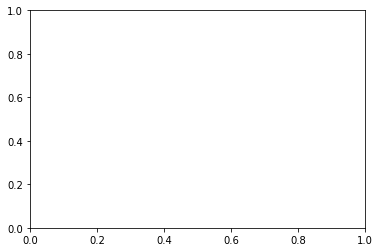

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), scores_mean, c='m', label='Average Scores')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [10]:
from ddpg_multiAgent import MultiAgent
multiAgent = MultiAgent(state_size=state_size, action_size=action_size, random_seed=2, num_agents = num_agents)

for i, agent in enumerate(multiAgent.ddpg_agents):
    agent.actor_local.load_state_dict(torch.load('trainedNN_actor_{}.pth'.format(i), map_location='cpu'))
    agent.actor_target.load_state_dict(torch.load('trainedNN_actor_{}.pth'.format(i), map_location='cpu'))
    agent.critic_local.load_state_dict(torch.load('trainedNN_critic_{}.pth'.format(i), map_location='cpu'))
    agent.critic_target.load_state_dict(torch.load('trainedNN_critic_{}.pth'.format(i), map_location='cpu'))

for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations       
    score = np.zeros(num_agents)               
    while True:
        actions = multiAgent.act(states, epsilon=0, add_noise=False)                       
        env_info = env.step(actions)[brain_name]        
        next_states = env_info.vector_observations     
        rewards = env_info.rewards       
        dones = env_info.local_done
        score += rewards
        states = next_states
        if np.any(dones):                              
            break
    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.mean(score)))

Episode: 	0 	Score: 	2.60
Episode: 	1 	Score: 	-0.00
Episode: 	2 	Score: 	0.15
